# Libraries

In [3]:
import argparse
import os
import torch
import torch.utils.data
from torch.utils.data import Subset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix
import joblib
import random
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameters

In [4]:
batch_size = 100
input_size = 784
hidden_size = 2048
epochs = 15
log_interval = 30
z_dim = 2
latent_dim = 256
lr = 0.001

# Data loading
Loading the test and train data set.

In [5]:
train_fashion = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test_fashion = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())

train_digit = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test_digit = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_arr, test_arr = [], []

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
def load_data(labels, name):
  if (name=='FashionMNIST'):
    train = train_fashion
    test = test_fashion
    n = len(train_fashion.classes)
  if (name=='MNIST'):
    train = train_digit
    test = test_digit
    n = len(train_digit.classes)

  K_indices= np.array([])
  K=int(labels/n)
  for i in range(n):
    indices = np.where(train.targets==i)
    K_indices = np.append(K_indices,np.random.choice(indices[0], size=K,replace=False))
    K_indices=torch.LongTensor(K_indices)
  new_train_data = Subset(train, K_indices)
  
  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

  train_loader = torch.utils.data.DataLoader(new_train_data, batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, **kwargs)

  return train_loader, test_loader


# VAE Model
The VAE network encodes the data by dimensionality reduction and then trying to reconstruct the data through the latent space.

In [8]:
class VAE(nn.Module):
  def __init__(self):
     super().__init__()
     self.fc1 = nn.Linear(input_size, hidden_size)
     self.fc21 = nn.Linear(hidden_size, latent_dim)
     self.fc22 = nn.Linear(hidden_size, latent_dim)
     self.fc3 = nn.Linear(latent_dim, hidden_size)
     self.fc4 = nn.Linear(hidden_size, input_size)

  def encoder(self, x):
    hidden = F.relu(self.fc1(x))
    mu = self.fc21(hidden)
    logvar = self.fc22(hidden)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.rand_like(std)
    return mu + eps*std

  def decoder(self, z):
    hidden = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(hidden))

  def forward(self, x):
    x = x.view(-1, input_size)
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

  def get_z(self,x):
    x = x.view(-1, input_size)
    mu, logvar = self.encoder(x)
    mu = mu.cpu().detach().numpy()
    return mu

def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x.view(-1,784), reduction='sum')
  KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar -1)
  return BCE +  KLD
  

# Train and test functions

In [9]:
def train(e, train_loader):
  model.train()
  tot_loss = 0
  for batch_i, (data, label) in enumerate(train_loader):
     optimizer.zero_grad()
     data = data.to(device)
     recon_x, mu, logvar = model(data)
     loss = loss_function(recon_x, data, mu, logvar)
     loss.backward()
     tot_loss += loss.item()
     optimizer.step()


  print("Epoch: {}/{}...".format(e+1, epochs),
          "Train Loss: {:.3f}...".format(tot_loss / len(train_loader.dataset)))    
  loss_plot['train'].append(tot_loss / len(train_loader.dataset))


def test(e, test_loader):
    model.eval()
    tot_loss = 0
    with torch.no_grad():
      for batch_i, (data, label) in enumerate(test_loader):
        data = data.to(device)
        recon_x, mu, logvar = model(data)
        loss = loss_function(recon_x, data, mu, logvar)
        tot_loss += loss.item()

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Test Loss: {:.3f}...".format(tot_loss / len(test_loader.dataset)))    
    loss_plot['test'].append(tot_loss / len(test_loader.dataset))


def latent_space(data_loader):
  model.eval()
  z, y = np.array([]), np.array([])
  with torch.no_grad():
    for batch_i, (data, label) in enumerate(test_loader):
      if z.size == 0:
        z = model.get_z(data)
      else:
        z = np.concatenate((z, model.get_z(data)), axis=0)
      
      if y.size == 0:
        y = label
      else:
        y = np.concatenate((y, label), axis=0)

  return z, y


def plot_fun(loss_plot, title):
    plt.plot(loss_plot['train'], label='train')    
    plt.plot(loss_plot['test'], label='test')
    plt.ylabel('Loss')    
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(title + '.png')
    plt.title(title)
    plt.show()    


# SVM Model

In [10]:
def SVM_model(x_train, y_train, x_test, y_test, n_labels, name):
  SVM_model = SVC(kernel = 'rbf', gamma = 'scale')
  SVM_model.fit(x_train, y_train)
  SVM_predict(SVM_model, n_labels, x_test, y_test, name)
  return SVM_model

def SVM_predict(svm_model, n_labels, x_test, y_test, name):
  predict = svm_model.predict(x_test)
  print(name, 'SVM for', n_labels, 'labels:')
  print('SVM Accuracy:', accuracy_score(y_test, predict), 'Errors: {:.2f}%'.format(100 - (accuracy_score(y_test, predict))*100), '\n')
  

# VAE for FashionMNIST

In [12]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loader, test_loader = load_data(6000, 'FashionMNIST')
loss_plot = {'train': [], 'test': []}
for e in range(epochs):
 train(e, train_loader)
 test(e, test_loader)

torch.save(model, '/content/drive/Shareddrives/ex3_q3_302377551_203092234/model_FashionMNIST.pt')



Epoch: 1/15... Train Loss: 332.626...
Epoch: 1/15... Test Loss: 285.453...
Epoch: 2/15... Train Loss: 272.452...
Epoch: 2/15... Test Loss: 263.463...
Epoch: 3/15... Train Loss: 259.101...
Epoch: 3/15... Test Loss: 257.979...
Epoch: 4/15... Train Loss: 254.491...
Epoch: 4/15... Test Loss: 253.771...
Epoch: 5/15... Train Loss: 251.464...
Epoch: 5/15... Test Loss: 251.475...
Epoch: 6/15... Train Loss: 248.753...
Epoch: 6/15... Test Loss: 248.598...
Epoch: 7/15... Train Loss: 246.762...
Epoch: 7/15... Test Loss: 247.728...
Epoch: 8/15... Train Loss: 245.367...
Epoch: 8/15... Test Loss: 246.149...
Epoch: 9/15... Train Loss: 243.814...
Epoch: 9/15... Test Loss: 245.070...
Epoch: 10/15... Train Loss: 242.733...
Epoch: 10/15... Test Loss: 244.148...
Epoch: 11/15... Train Loss: 241.140...
Epoch: 11/15... Test Loss: 242.886...
Epoch: 12/15... Train Loss: 240.401...
Epoch: 12/15... Test Loss: 242.606...
Epoch: 13/15... Train Loss: 239.709...
Epoch: 13/15... Test Loss: 241.274...
Epoch: 14/15... T

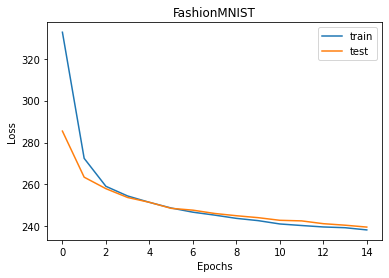

In [13]:
plot_fun(loss_plot, 'FashionMNIST')

# SVM Training for FashionMNIST

In [14]:
labels = [100, 600, 1000, 3000]
for label in labels:
  train_loader_fashion, test_loader_fashion = load_data(label, 'FashionMNIST')
  x_train_fashion, y_train_fashion = latent_space(train_loader_fashion)
  x_test_fashion, y_test_fashion = latent_space(test_loader_fashion)
  new_model = SVM_model(x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion, label,name='FashionMNIST')
  filename = '/content/drive/Shareddrives/ex3_q3_302377551_203092234/SVM_'+str(label)+'_FashionMNIST.sav'
  joblib.dump(new_model, open(filename, 'wb'))

FashionMNIST SVM for 100 labels:
SVM Accuracy: 0.8648 Errors: 13.52% 

FashionMNIST SVM for 600 labels:
SVM Accuracy: 0.8649 Errors: 13.51% 

FashionMNIST SVM for 1000 labels:
SVM Accuracy: 0.8648 Errors: 13.52% 

FashionMNIST SVM for 3000 labels:
SVM Accuracy: 0.8649 Errors: 13.51% 



# VAE for MNIST

In [15]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loader, test_loader = load_data(6000, 'MNIST')
loss_plot = {'train': [], 'test': []}
for e in range(epochs):
 train(e, train_loader)
 test(e, test_loader)

torch.save(model, '/content/drive/Shareddrives/ex3_q3_302377551_203092234/model_MNIST.pt')

Epoch: 1/15... Train Loss: 220.066...
Epoch: 1/15... Test Loss: 191.819...
Epoch: 2/15... Train Loss: 170.323...
Epoch: 2/15... Test Loss: 150.171...
Epoch: 3/15... Train Loss: 142.697...
Epoch: 3/15... Test Loss: 133.007...
Epoch: 4/15... Train Loss: 128.816...
Epoch: 4/15... Test Loss: 121.903...
Epoch: 5/15... Train Loss: 119.472...
Epoch: 5/15... Test Loss: 114.857...
Epoch: 6/15... Train Loss: 113.457...
Epoch: 6/15... Test Loss: 109.871...
Epoch: 7/15... Train Loss: 108.999...
Epoch: 7/15... Test Loss: 106.681...
Epoch: 8/15... Train Loss: 105.549...
Epoch: 8/15... Test Loss: 103.938...
Epoch: 9/15... Train Loss: 102.732...
Epoch: 9/15... Test Loss: 101.863...
Epoch: 10/15... Train Loss: 100.565...
Epoch: 10/15... Test Loss: 99.382...
Epoch: 11/15... Train Loss: 98.650...
Epoch: 11/15... Test Loss: 98.455...
Epoch: 12/15... Train Loss: 96.987...
Epoch: 12/15... Test Loss: 97.367...
Epoch: 13/15... Train Loss: 95.718...
Epoch: 13/15... Test Loss: 96.583...
Epoch: 14/15... Train Lo

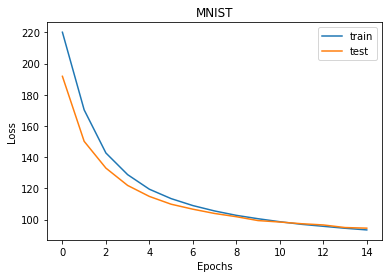

In [16]:
plot_fun(loss_plot, 'MNIST')

# SVM Training for MNIST




In [17]:
labels = [100, 600, 1000, 3000]
for label in labels:
  train_loader_digit, test_loader_digit = load_data(label, 'MNIST')
  x_train_digit, y_train_digit = latent_space(train_loader_digit)
  x_test_digit, y_test_digit = latent_space(test_loader_digit)
  new_model = SVM_model(x_train_digit, y_train_digit, x_test_digit, y_test_digit, label, name='MNIST')
  filename = '/content/drive/Shareddrives/ex3_q3_302377551_203092234/SVM_'+str(label)+'_MNIST.sav'
  joblib.dump(new_model, open(filename, 'wb'))

MNIST SVM for 100 labels:
SVM Accuracy: 0.9898 Errors: 1.02% 

MNIST SVM for 600 labels:
SVM Accuracy: 0.9898 Errors: 1.02% 

MNIST SVM for 1000 labels:
SVM Accuracy: 0.9898 Errors: 1.02% 

MNIST SVM for 3000 labels:
SVM Accuracy: 0.9898 Errors: 1.02% 



# Loading the models
VAE for FashionMNIST

In [18]:
model = torch.load('/content/drive/Shareddrives/ex3_q3_302377551_203092234/model_FashionMNIST.pt')
test(0, test_loader)

Epoch: 1/15... Test Loss: 183.865...


VAE for MNIST

In [19]:
model = torch.load('/content/drive/Shareddrives/ex3_q3_302377551_203092234/model_MNIST.pt')
test(0, test_loader)

Epoch: 1/15... Test Loss: 94.510...
